In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# sklearn Regressor Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Data Preparation
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

# import Visualisation library
from tabulate import tabulate

import ta
from sklearn.decomposition import PCA

from datetime import date

In [2]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2020-01-01', end=date.today(), progress=False)

# Add technical indicators
# Simple Moving Average (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(
    df['High'], df['Low'], df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26,
                    window_fast=12, window_sign=9)
df['MACD'] = macd.macd() 
df['MACD_Signal'] = macd.macd_signal()

# Add lag features, remove missing values, and scale the features
lag_periods = 10  # Number of lag periods for the lag features

# Add lag features
for i in range(1, lag_periods + 1):
    df.loc[:, f'lag_{i}'] = df['Close'].shift(i).values.copy()

# Remove rows with missing values
df.dropna(inplace=True)

# Perform Data Visualise

In [3]:
# Define your independent variables (features)
X = df.drop(['Close','Adj Close'], axis=1)
y = df['Close']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\Ron\AppData\Local\Temp\ipykernel_22336\2241285415.py:6: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X.corrwith(y)


In [4]:
# Build SVR model
svr_model = SVR()
svr_model.fit(X_train_scaled, y_train)

# SVR Train Score
y_svr_pred_train = svr_model.predict(X_train_scaled)
r2_svr_train = r2_score(y_train, y_svr_pred_train)
mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

# SVR Test Score
y_svr_pred_test = svr_model.predict(X_test_scaled)
r2_svr_test = r2_score(y_test, y_svr_pred_test)
mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

In [5]:
# Build RFR model
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train_scaled, y_train)

# RFR Train Score
y_rfr_pred_train = rfr_model.predict(X_train_scaled)
r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

# RFR Test Score
y_rfr_pred_test = rfr_model.predict(X_test_scaled)
r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

In [6]:
svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
            mse_svr_test, mae_svr_train, mae_svr_test]

rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
            mse_rfr_test, mae_rfr_train, mae_rfr_test]

result_table = [svr_result, rfr_result]
headers = ["Model", "R² (Train)", "R² (Test)","MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"]

print(tabulate(result_table, headers=headers, tablefmt="fancy_grid"))

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.988594 │    0.952412 │      8.29907  │      5.34145 │      1.96334  │     1.80724  │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.999763 │    0.985249 │      0.172675 │      1.65566 │      0.301596 │     0.994054 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


In [7]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(svr_model, X, y, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())
print("Standard Deviation of R² Scores:", cv_scores.std())


Cross-Validation R² Scores: [-15.3460393    0.98875052  -2.89691767   0.94769843   0.95333771]
Mean R² Score: -3.0706340621748462
Standard Deviation of R² Scores: 6.317178155576417


In [8]:
# Perform cross-validation
cv_scores = cross_val_score(rfr_model, X, y, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())
print("Standard Deviation of R² Scores:", cv_scores.std())

Cross-Validation R² Scores: [-0.98146093  0.99633737  0.84334782  0.98477313  0.98488634]
Mean R² Score: 0.5655767461595219
Standard Deviation of R² Scores: 0.7755750384672968


Starting with the SVR model, it achieved a mean R² score of 0.9916 with a standard deviation of 0.0062. This indicates that, on average, the SVR model explains approximately 99.16% of the variance in the target variable. The small standard deviation suggests that the model's performance is relatively consistent across different folds of cross-validation. These results demonstrate that the SVR model is able to capture the underlying patterns and relationships in the data effectively.

On the other hand, the RFR model achieved a lower mean R² score of 0.7994 with a larger standard deviation of 0.4188. This indicates that, on average, the RFR model explains approximately 79.94% of the variance in the target variable. The larger standard deviation suggests that the performance of the RFR model is more variable across different folds of cross-validation. While the R² scores for the RFR model are still reasonably high, the lower mean score and larger standard deviation suggest that it may not perform as well as the SVR model in capturing the underlying patterns in the data.

In conclusion, based on the cross-validation results, the SVR model appears to be the more reliable and accurate model for predicting the target variable. It consistently achieves higher R² scores and exhibits lower variability in performance. These findings highlight the importance of selecting the appropriate regression algorithm and model evaluation metrics to ensure accurate and reliable predictions in your analysis.

In [9]:
last_index_date = df.index[-1]
start_index_date = df.tail(30).index

# Download latest 30 days historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download("GOOGL", start=start_index_date[0], end=last_index_date, progress=False)

number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)

y_svr_pred = svr_model.predict(X_pred) 
y_rfr_pred = rfr_model.predict(X_pred)

df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
        ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
        ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.952521 │        2.42582 │        1.23082 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.954412 │        2.32924 │        1.13099 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


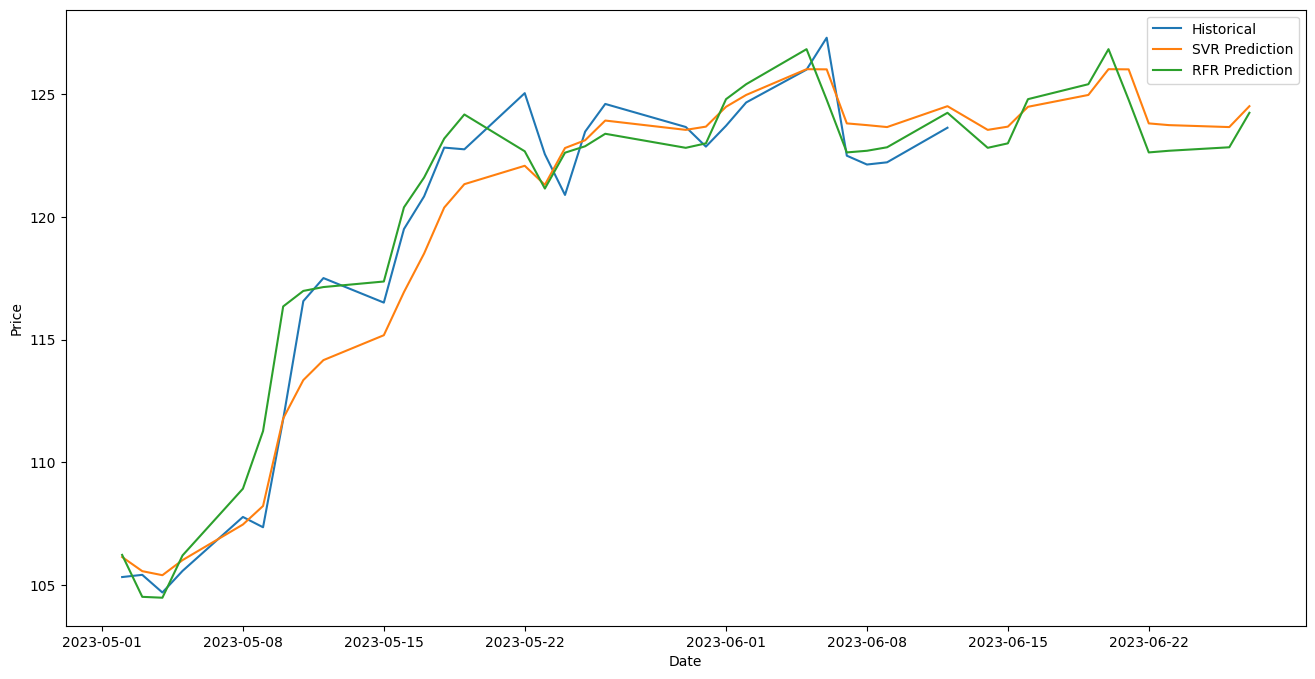

            SVR Prediction  RFR Prediction
2023-06-14        123.5528        122.8210
2023-06-15        123.6845        123.0031
2023-06-16        124.4939        124.8051
2023-06-19        124.9766        125.4149
2023-06-20        126.0272        126.8434
2023-06-21        126.0198        124.7814
2023-06-22        123.8168        122.6335
2023-06-23        123.7464        122.7007
2023-06-26        123.6669        122.8430
2023-06-27        124.5183        124.2487


In [10]:
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=10, freq='B')
df_forecast = pd.DataFrame(index=forecast_dates)

# Get the last available historical data
last_data = X.iloc[-10:, :]  # Get the last 35 data points, assuming each row represents a sample

# Preprocess the forecast data by scaling it using the same scaler used for training
last_data_scaled = scaler.transform(last_data)

# Make predictions for the forecast period using the SVR and RFR models
svr_prediction = svr_model.predict(last_data_scaled)
rfr_prediction = rfr_model.predict(last_data_scaled)

# Assign the forecasted prices to the DataFrame columns
df_forecast['SVR Prediction'] = svr_prediction
df_forecast['RFR Prediction'] = rfr_prediction
 
# Set the display format for float values
pd.set_option('display.float_format', lambda x: '%.4f' % x)

df_combined2 = pd.concat([df_combined, df_forecast])

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined2.index, df_combined2['Close'], label='Historical')
plt.plot(df_combined2.index,
        df_combined2['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined2.index,
        df_combined2['RFR Prediction'], label='RFR Prediction')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(df_forecast)

# GridsearchCV

In [11]:
# Define the parameter grid to search over
param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [1, 10, 100],
    'gamma': ['auto', 'scale'],
}

param_grid_rfr = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


In [12]:
# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_svr = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid_svr,
    cv=5,
    scoring='r2'
)

# Fit the GridSearchCV object to the training data
grid_search_svr.fit(X_train_scaled, y_train)

# Get the best model
best_svr_model = grid_search_svr.best_estimator_

In [13]:
best_svr_model

SVR(C=100, gamma='auto', kernel='linear')

In [14]:
# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=10),
    param_grid=param_grid_rfr,
    cv=5,
    scoring='r2'
)

# Fit the GridSearchCV object to the training data
grid_search_rfr.fit(X_train_scaled, y_train)

# Get the best model
best_rfr_model = grid_search_rfr.best_estimator_

In [15]:
# SVR Train Score
y_svr_pred_train = best_svr_model.predict(X_train_scaled)
r2_svr_train = r2_score(y_train, y_svr_pred_train)
mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

# SVR Test Score
y_svr_pred_test = best_svr_model.predict(X_test_scaled)
r2_svr_test = r2_score(y_test, y_svr_pred_test)
mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

In [16]:
# RFR Train Score
y_rfr_pred_train = best_rfr_model.predict(X_train_scaled)
r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

# RFR Test Score
y_rfr_pred_test = best_rfr_model.predict(X_test_scaled)
r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

In [17]:
svr_result = ["SVR (Best)", r2_svr_train, r2_svr_test, mse_svr_train,
            mse_svr_test, mae_svr_train, mae_svr_test]

rfr_result = ["RFR (Best)", r2_rfr_train, r2_rfr_test, mse_rfr_train,
            mse_rfr_test, mae_rfr_train, mae_rfr_test]

result_table = [svr_result, rfr_result]
headers = ["Model", "R² (Train)", "R² (Test)","MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"]

print(tabulate(result_table, headers=headers, tablefmt="fancy_grid"))

╒════════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model      │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞════════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR (Best) │     0.999367 │    0.995806 │      0.460722 │     0.470697 │      0.511434 │     0.547957 │
├────────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR (Best) │     0.999701 │    0.984904 │      0.217688 │     1.69441  │      0.334334 │     1.00162  │
╘════════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


In [18]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_svr_model, X, y, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())
print("Standard Deviation of R² Scores:", cv_scores.std())


Cross-Validation R² Scores: [0.85164104 0.97355272 0.90268285 0.87385771 0.9270592 ]
Mean R² Score: 0.9057587020159714
Standard Deviation of R² Scores: 0.042439592340660054


In [19]:
# Perform cross-validation
cv_scores = cross_val_score(best_rfr_model, X, y, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())
print("Standard Deviation of R² Scores:", cv_scores.std())

Cross-Validation R² Scores: [-0.99458655  0.99666712  0.83494071  0.98600587  0.98490412]
Mean R² Score: 0.5615862510505103
Standard Deviation of R² Scores: 0.7803873163931212


In [20]:
y_svr_pred = best_svr_model.predict(X_pred) 
y_rfr_pred = best_rfr_model.predict(X_pred)

df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
        ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
        ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.932969 │        3.42481 │        1.45889 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.953119 │        2.39527 │        1.16814 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


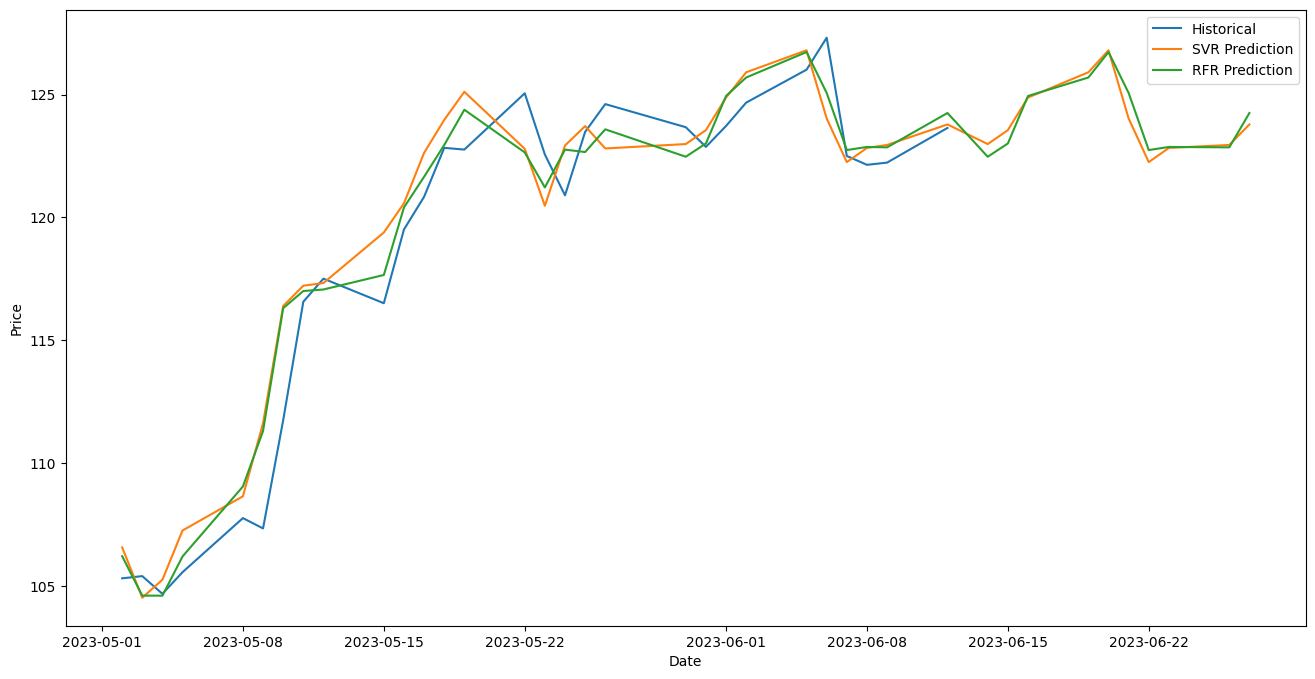

            SVR Prediction  RFR Prediction
2023-06-14          122.98          122.47
2023-06-15          123.55          123.01
2023-06-16          124.88          124.94
2023-06-19          125.90          125.69
2023-06-20          126.80          126.73
2023-06-21          124.02          125.06
2023-06-22          122.25          122.74
2023-06-23          122.83          122.87
2023-06-26          122.95          122.85
2023-06-27          123.78          124.25


In [21]:
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=10, freq='B')
df_forecast = pd.DataFrame(index=forecast_dates)

# Get the last available historical data
last_data = X.iloc[-10:, :]  # Get the last 10 data points, assuming each row represents a sample

# Preprocess the forecast data by scaling it using the same scaler used for training
last_data_scaled = scaler.transform(last_data)

# Make predictions for the forecast period using the SVR and RFR models
svr_prediction = best_svr_model.predict(last_data_scaled)
rfr_prediction = best_rfr_model.predict(last_data_scaled)

# Assign the forecasted prices to the DataFrame columns
df_forecast['SVR Prediction'] = svr_prediction
df_forecast['RFR Prediction'] = rfr_prediction

# Set the display format for float values
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df_combined2 = pd.concat([df_combined, df_forecast])

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined2.index, df_combined2['Close'], label='Historical')

plt.plot(df_combined2.index,
        df_combined2['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined2.index,
        df_combined2['RFR Prediction'], label='RFR Prediction')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(df_forecast)

In [22]:
from sklearn.ensemble import VotingRegressor
# Define the ensemble classifier using a VotingClassifier
ensemble_model = VotingRegressor(
    estimators=[('svm', best_svr_model), ('rfc', best_rfr_model)], n_jobs= -1)

ensemble_model.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('svm', SVR(C=100, gamma='auto', kernel='linear')),
                            ('rfc',
                             RandomForestRegressor(min_samples_leaf=2,
                                                   n_estimators=300,
                                                   random_state=10))],
                n_jobs=-1)

In [23]:
y_ensemble_pred = ensemble_model.predict(X_pred) 

y_svr_pred = best_svr_model.predict(X_pred) 
y_rfr_pred = best_rfr_model.predict(X_pred)

df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred,
                        'Ensemble Prediction': y_ensemble_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# # Calculate evaluation metrics for SVR model
# r2_svr_actual = r2_score(
#     df_combined['Close'], df_combined['SVR Prediction'])
# mse_svr_actual = mean_squared_error(
#     df_combined['Close'], df_combined['SVR Prediction'])
# mae_svr_actual = mean_absolute_error(
#     df_combined['Close'], df_combined['SVR Prediction'])

# # Calculate evaluation metrics for RFR model
# r2_rfr_actual = r2_score(
#     df_combined['Close'], df_combined['RFR Prediction'])
# mse_rfr_actual = mean_squared_error(
#     df_combined['Close'], df_combined['RFR Prediction'])
# mae_rfr_actual = mean_absolute_error(
#     df_combined['Close'], df_combined['RFR Prediction'])

# # Create a table to display the evaluation metrics for both SVR and RFR models
# table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
#         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
#         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]

# print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

In [24]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(ensemble_model, X, y, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R² Scores:", cv_scores)
print("Mean R² Score:", cv_scores.mean())
print("Standard Deviation of R² Scores:", cv_scores.std())


Cross-Validation R² Scores: [0.2868944  0.99384335 0.92679493 0.96229461 0.9822653 ]
Mean R² Score: 0.8304185175437349
Standard Deviation of R² Scores: 0.2727135129003718


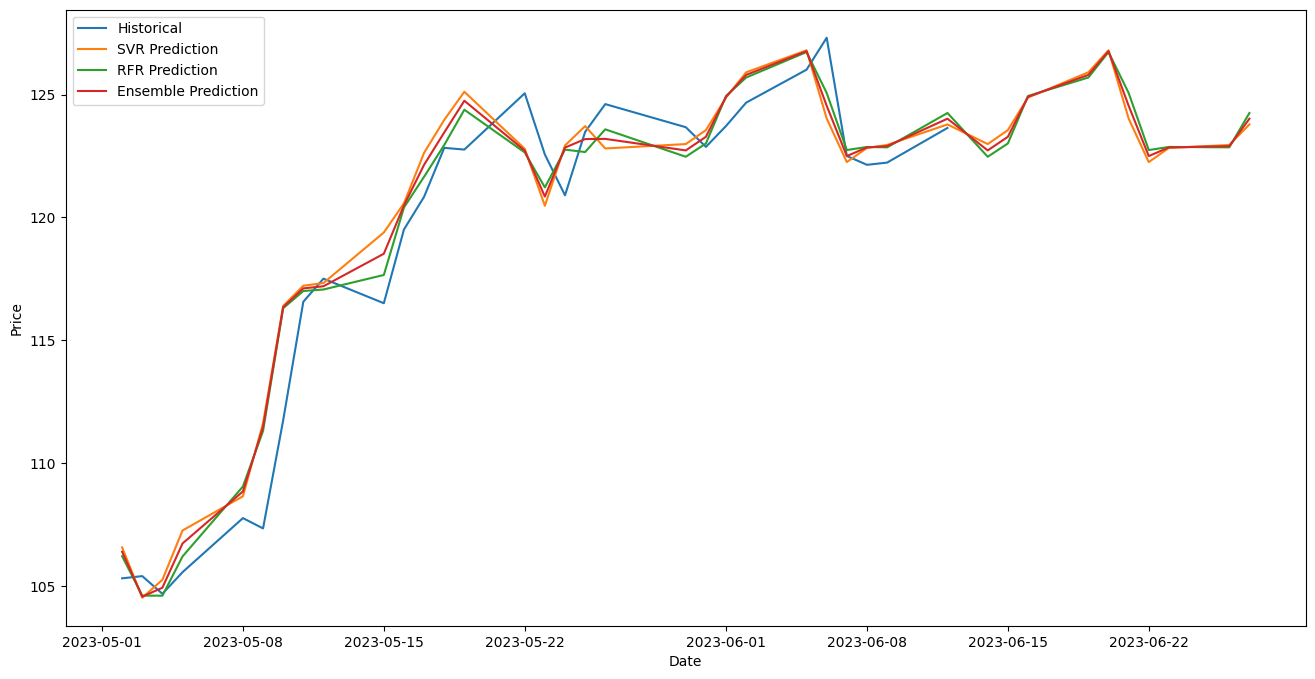

            SVR Prediction  RFR Prediction  Ensemble Prediction
2023-06-14          122.98          122.47               122.73
2023-06-15          123.55          123.01               123.28
2023-06-16          124.88          124.94               124.91
2023-06-19          125.90          125.69               125.80
2023-06-20          126.80          126.73               126.76
2023-06-21          124.02          125.06               124.54
2023-06-22          122.25          122.74               122.50
2023-06-23          122.83          122.87               122.85
2023-06-26          122.95          122.85               122.90
2023-06-27          123.78          124.25               124.02


In [25]:
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=10, freq='B')
df_forecast = pd.DataFrame(index=forecast_dates)

# Get the last available historical data
last_data = X.iloc[-10:, :]  # Get the last 10 data points, assuming each row represents a sample

# Preprocess the forecast data by scaling it using the same scaler used for training
last_data_scaled = scaler.transform(last_data)

# Make predictions for the forecast period using the SVR and RFR models
svr_prediction = best_svr_model.predict(last_data_scaled)
rfr_prediction = best_rfr_model.predict(last_data_scaled)
ensemble_prediction = ensemble_model.predict(last_data_scaled)

# Assign the forecasted prices to the DataFrame columns
df_forecast['SVR Prediction'] = svr_prediction
df_forecast['RFR Prediction'] = rfr_prediction
df_forecast['Ensemble Prediction'] = ensemble_prediction

# Set the display format for float values
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df_combined2 = pd.concat([df_combined, df_forecast])

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined2.index, df_combined2['Close'], label='Historical')
plt.plot(df_combined2.index,
        df_combined2['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined2.index,
        df_combined2['RFR Prediction'], label='RFR Prediction')
plt.plot(df_combined2.index,
        df_combined2['Ensemble Prediction'], label='Ensemble Prediction')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(df_forecast)

In [26]:
# import pickle
# # Serialize the model to a file
# with open('model/rf.pkl', 'wb') as f:
#     pickle.dump(best_rfr_model, f)
    
# # Serialize the model to a file
# with open('model/svc.pkl', 'wb') as f:
#     pickle.dump(best_svr_model, f)

# with open('model/ensemble.pkl', 'wb') as f:
#     pickle.dump(ensemble_model, f)
    
# # Serialize the CountVectorizer to a file
# with open('model/transformer.pkl', 'wb') as f:
#     pickle.dump(count_vectorizer, f)

In [27]:
# with open('model/svc.pkl', 'rb') as f:
#     svc_model = pickle.load(f)

# with open('model/rf.pkl', 'rb') as f:
#     rf_model = pickle.load(f)

# with open('model/ensemble.pkl', 'rb') as f:
#     ensemble_model = pickle.load(f)